# Project 3

### How strong is the “home bias” in the demand for cars, and how does that affect the own-price elasticity of demand?

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
sns.set_theme()
import clogit_project3
import estimation as est
from numpy import linalg as la
from scipy import optimize
import LinearModels as lm

import statsmodels.formula.api as smf
import matplotlib.ticker as mtick

# Read in data

The dataset, `cars.csv`, contains cleaned and processed data. If you want to make changes, the notebook, `materialize.ipynb`, creates the data from the raw source datsets. 

In [2]:
# read data
cars = pd.read_csv('cars.csv')
lbl_vars = pd.read_csv('labels_variables.csv')
lbl_vals = pd.read_csv('labels_values.csv')

In [3]:
# convert from dataframe to dict
lbl_vals = {c: lbl_vals[c].dropna().to_dict() for c in lbl_vals.columns}
lbl_vars.set_index('variable', inplace=True)

# Set up for analysis

In [4]:
price_var = 'princ'
cars['logp'] = np.log(cars[price_var])
# new variable: price elasticity heterogeneous for home-region 
cars['logp_x_home'] = cars[price_var] * cars['home']
cars['size'] = cars['he'] * cars['le'] * cars['wi']

In [5]:
brand_dummies = pd.get_dummies(cars['brand']) # creates a matrix of dummies for each value of dummyvar
brand_dummies_list = list(brand_dummies.columns[1:].values) # omit a reference category, here it is the first (hence columns[1:])

loc_dummies = pd.get_dummies(cars['loc']) 
loc_dummies_list = list(loc_dummies.columns[1:].values)

# add dummies to the dataframe 
#assert brand_dummies.columns[0] not in cars.columns, f'It looks like you have already added this dummy to the dataframe. Avoid duplicates! '
cars = pd.concat([cars,brand_dummies,loc_dummies], axis=1)

# select x_vars
standardize = [
    'size'
    , 'li'
    , 'hp'
]

dont_standardize = [
    'logp'
    , 'logp_x_home'
    , 'home'
]

x_vars = standardize + dont_standardize #+ brand_dummies_list #+ loc_dummies_list

print(f'K = {len(x_vars)} variables selected.')

K = len(x_vars)
N = cars.ma.nunique() * cars.ye.nunique()
J = 40
x = cars[x_vars].values.reshape((N,J,K))
y = (cars['s'].values.reshape((N,J)))

# standardize x
stop = len(standardize)
start = 0
x[:, :, start:stop] = ((x[:, :, start:stop] - x[:, :, start:stop].mean(0).mean(0))/(x[:, :, start:stop].std(0).std(0)))
# "bange for at nogen variable driver det for meget"
# "singular matrix = collinearity"

K = 6 variables selected.


In [6]:
pairs = [
    ('Nelder-Mead', 'Outer Product')
    , ('BFGS', 'Hessian')
    , ('BFGS', 'Sandwich')
]

list_of_dfs = []

for pair in pairs:
    print('____________________________________________')
    print(f'              \n{pair}\n')
    method = pair[0]
    cov_type = pair[1]
    
    res = est.estimate(clogit_project3.q
                       , clogit_project3.starting_values(y, x)
                       , y
                       , x
                       , method=method
                       , cov_type=cov_type
                       , options={
                           'disp':True
                           ,'maxiter':30000
                       }
                      )
    
    temp = pd.DataFrame({v:res[v] for v in ['theta', 'se', 't']})
    temp['method'] = [method for i in range(temp.shape[0])]
    temp['cov_type'] = [cov_type for i in range(temp.shape[0])]
    temp['x_var'] = x_vars
    
    list_of_dfs.append(temp)
    
res_df = pd.concat(list_of_dfs, ignore_index=True)

____________________________________________
              
('Nelder-Mead', 'Outer Product')

Optimization terminated successfully.
         Current function value: 3.499303
         Iterations: 1007
         Function evaluations: 1568
____________________________________________
              
('BFGS', 'Hessian')

Optimization terminated successfully.
         Current function value: 3.499303
         Iterations: 26
         Function evaluations: 203
         Gradient evaluations: 29
____________________________________________
              
('BFGS', 'Sandwich')

Optimization terminated successfully.
         Current function value: 3.499303
         Iterations: 26
         Function evaluations: 203
         Gradient evaluations: 29


In [7]:
desired_pair = ('BFGS', 'Sandwich')
#desired_pair = ('Nelder-Mead', 'Outer Product')
thetahat = res_df[(res_df.method == desired_pair[0]) & (res_df.cov_type == desired_pair[1])].theta.to_numpy().flatten()

choice1 = clogit_project3.choice_prob(thetahat, x)

In [8]:
res_df

,theta,se,t,method,cov_type,x_var
0,0.010163,0.150608,0.067480,Nelder-Mead,Outer Product,size
1,0.001004,0.130772,0.007674,Nelder-Mead,Outer Product,li
2,-0.047294,0.256405,-0.184449,Nelder-Mead,Outer Product,hp
3,0.306013,7.064799,0.043315,Nelder-Mead,Outer Product,logp
4,-0.513816,6.988795,-0.073520,Nelder-Mead,Outer Product,logp_x_home
5,1.680286,5.156757,0.325842,Nelder-Mead,Outer Product,home
6,0.010159,0.002620,3.877435,BFGS,Hessian,size
7,0.001002,0.002350,0.426451,BFGS,Hessian,li
8,-0.047310,0.004418,-10.707688,BFGS,Hessian,hp
9,0.306540,0.108867,2.815723,BFGS,Hessian,logp


In [9]:
# Restrict homemarket estimate to zero
thetahat_nohome = thetahat
thetahat_nohome[5] =0

In [10]:
choice2 = clogit_project3.choice_prob(thetahat_nohome, x)

In [11]:
with_home = np.zeros((5,40))
without_home = np.zeros((5,40))

for idx, market in enumerate(np.split(choice1, 5)):
    with_home[idx, :] = market.mean(0, keepdims=True)
    
for idx, market in enumerate(np.split(choice2, 5)):
    without_home[idx, :] = market.mean(0, keepdims=True)  

In [12]:
#origin = pd.melt(pd.DataFrame(cars.values.reshape((N,J,len(cars.columns)))[:,:,8]),var_name="alternative",value_name="org")

In [13]:
# Create,melt and join dataframe with cars df
s_no_home = pd.melt(pd.DataFrame(choice2),var_name="alternative",value_name="s_no_home")
s_no_home.head()

,alternative,s_no_home
0,0,0.020918
1,0,0.033654
2,0,0.021044
3,0,0.024382
4,0,0.024331


In [14]:
cars = cars.join(s_no_home)
cars.head()

,ye,ma,co,zcode,brd,type,brand,model,org,loc,...,6,7,8,10,11,12,15,16,alternative,s_no_home
0,70,1,15,14,2,audi 100/200,audi,100/200,2,4,...,0,0,0,0,0,0,0,0,0,0.020918
1,70,1,26,35,4,citroen 2 CV 6 - 2 CV 4,citroen,2CV6,1,3,...,0,0,0,0,0,0,0,0,0,0.033654
2,70,1,36,36,4,citroen dyane,citroen,dyane,1,3,...,0,0,0,0,0,0,0,0,0,0.021044
3,70,1,64,67,7,fiat 128,fiat,128,3,5,...,0,0,0,0,0,0,0,0,0,0.024382
4,70,1,71,80,8,ford escort,ford,escort,2,4,...,0,0,0,0,0,0,0,0,0,0.024331


In [15]:
# Change origin variable
# 1: France, 2:Germany,3:Italy,4:UK,5:other (US,sweden,spain,brazil,eastern europe)
cars.org.replace([4,5,6,8],9,inplace=True)

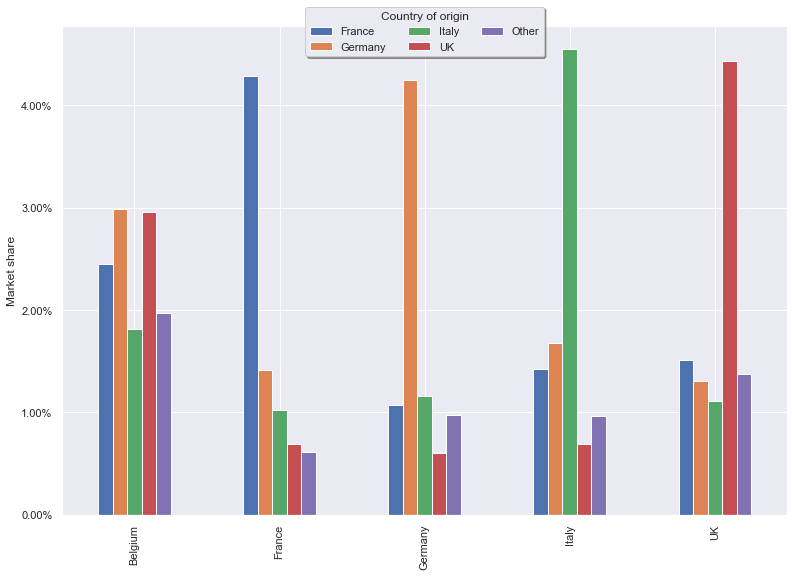

In [16]:
# Plot country of origin against observed marketshares
fig_data = cars.groupby(["ma","org"]).s.mean()*100
ax = fig_data.unstack().plot.bar(figsize=(13, 9))
plt.legend(["France","Germany","Italy","UK","Other"],title="Country of origin",loc='upper center', bbox_to_anchor=(0.5, 1.05),
          ncol=3, fancybox=True, shadow=True)
plt.xticks([0,1,2,3,4],["Belgium","France","Germany","Italy","UK"])
ax.set_xlabel("")
ax.set_ylabel("Market share")
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
plt.savefig("observed_marketshares.png")

In [17]:
pd.crosstab(index=cars.org,columns=cars.ma,values=cars.s,aggfunc='mean')*100

ma,1,2,3,4,5
org,,,,,
1,2.449147,4.292359,1.077182,1.426203,1.510021
2,2.983261,1.412171,4.251669,1.679373,1.307593
3,1.819520,1.023603,1.158308,4.552964,1.116674
7,2.956192,0.689838,0.607516,0.693741,4.432616
9,1.969689,0.616620,0.979909,0.969567,1.375601


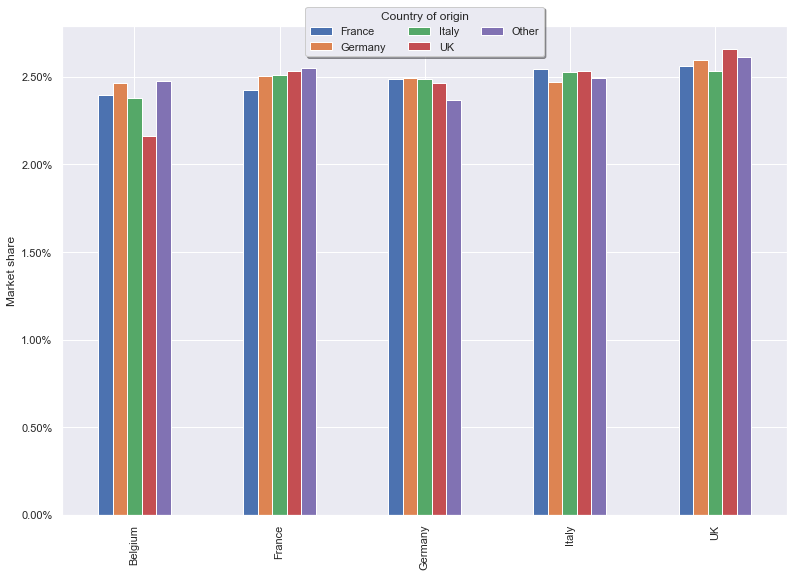

In [18]:
# Plot country of origin against predicted marketshares with no homemarket bias
fig_data = cars.groupby(["ma","org"]).s_no_home.mean()*100
ax = fig_data.unstack().plot.bar(figsize=(13, 9))
plt.legend(["France","Germany","Italy","UK","Other"],title="Country of origin",loc='upper center', bbox_to_anchor=(0.5, 1.05),
          ncol=3, fancybox=True, shadow=True)
plt.xticks([0,1,2,3,4],["Belgium","France","Germany","Italy","UK"])
ax.set_xlabel("")
ax.set_ylabel("Market share")
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
plt.savefig("predicted_marketshares.png")

In [19]:
pd.crosstab(index=cars.org,columns=cars.ma,values=cars.s_no_home,aggfunc='mean')*100

ma,1,2,3,4,5
org,,,,,
1,2.395507,2.423794,2.485326,2.543400,2.561330
2,2.463269,2.507173,2.493738,2.468293,2.595312
3,2.381067,2.508758,2.486389,2.529594,2.533010
7,2.159590,2.530354,2.466789,2.535563,2.659360
9,2.474338,2.552317,2.369508,2.492480,2.615523


In [20]:
pd.crosstab(index=cars.home,columns=cars.ma,values=cars.princ,aggfunc='mean').round(1)

ma,1,2,3,4,5
home,,,,,
0,0.6,0.7,0.5,0.9,0.9
1,NaN,0.7,0.7,0.9,1.0


### Partial effect
$$
    \frac{\partial}{\partial x_kl} Pr(j) = Pr(j) \left[\boldsymbol{1}_{k=j} \beta_{l} -  Pr(l) \beta_{l} \right]
$$

### Price-elasticity of demand
$$
\boldsymbol{\epsilon}_{jj}(\boldsymbol{X}_{i}) = \frac{\partial s_j(\boldsymbol{X}_{i}, \boldsymbol{\beta})}{\partial p_{ij}} \frac{p_{ij}}{s_j(\boldsymbol{X}_{i}, \boldsymbol{\beta})}
$$

In [21]:
# Extract parameter estimates
desired_pair = ('BFGS', 'Sandwich')
#desired_pair = ('Nelder-Mead', 'Outer Product')
thetahat = res_df[(res_df.method == desired_pair[0]) & (res_df.cov_type == desired_pair[1])].theta.to_numpy().flatten()

# Original choice probabilites
ccp1 = clogit_project3.choice_prob(thetahat, x)
ccp1[0].sum()

1.0

In [23]:
E_own   = np.zeros((N, J))
E_cross = np.zeros((N, J))
dpdx    = np.zeros((N, J))

for j in range(J):
    # A. copy 
    x2 = x.copy()
    
    # B. increase price just for car j 
    rel_change_x = 0.01
    x2[:, j, 3] = x2[:, j, 3] * (1+rel_change_x)

    # C. evaluate CCPs
    ccp2 = clogit_project3.choice_prob(thetahat, x2)
    
    # D. percentage change in CCPs 
    rel_change_y = ccp2 / ccp1 - 1
    
    # E. elasticities 
    elasticity = rel_change_y / rel_change_x
    
    E_own[:, j] = elasticity[:, j] # Fill in 

    k_not_j = [k for k in range(J) if k != j] # indices for all other cars than j 
    E_cross[:, j] = elasticity[:, k_not_j].mean(axis=1) # Fill in: Avg. among the cars k_not_j

In [24]:
# Create,melt and join dataframe with cars df
own_elasticity= pd.melt(pd.DataFrame(E_own),var_name="alt",value_name="E_own")

In [25]:
cars = cars.join(own_elasticity)

In [26]:
cars.groupby(["ma","home"]).E_own.mean().round(3)

ma  home
1   0       37.573
2   0       38.443
    1       39.335
3   0       38.893
    1       38.629
4   0       41.968
    1       43.168
5   0       35.553
    1       38.144
Name: E_own, dtype: float64

In [27]:
print(f'Own-price elasticity:  {np.mean(E_own).round(7)}')
print(f'Cross-price elasticity: {np.mean(E_cross).round(7)}')

Own-price elasticity:  38.8088353
Cross-price elasticity: -1.3457659


In [28]:
home = 5
print(x_vars[home]) # check that we found the right one 
assert x_vars[home] == 'home'

# Create two indexed, from where idx1 is for electric cars and idx0 is for non-electric cars.
idx1 = x[:, :, home]==1
idx0 = x[:, :, home]==0 
print(f'Elasticity, home:  {np.mean(E_own[idx1]).round(4)}')
print(f'Elasticity, other: {np.mean(E_own[idx0]).round(4)}')

home
Elasticity, home:  70.3529
Elasticity, other: 24.2133


### Compensating Variation

We can compare welfare under $v_{ij}$ and $\tilde{v}_{ij}$:

$$
CV = \frac{1}{\beta_1} \log \sum_{j=1}^{J} \exp{v_{ij}} - \frac{1}{\beta_1} \log \sum_{j=1}^{J} \exp{\tilde{v}_{ij}}
$$